In [1]:
# Core Libraries
import pandas as pd  # For creating and manipulating dataframes
import numpy as np  # For fast calculations
# Models
import statsmodels.api as sm  # For linear regression
import statsmodels.tsa as ts  # For time series analyses
from sklearn.ensemble import RandomForestRegressor  # Random Forest algorithm
import lightgbm as lgb  # Great gradient boosted trees algorithm written by microsoft
# Deep learning
import torch  # PyTorch library
import torch.nn as nn  # Module for creating neural networks
import torch.nn.F as F  #
import torch.optim as opt


# Plotting
import matplotlib.pyplot as plt
plt.style.use('bmh')  # With this line you change the style of the plots so they're prettier
# The line below this comment allows you to view plots directly in jupyter
%matplotlib inline

# Utils
import warnings
warnings.filterwarnings('ignore')  # Remove annoying warnings

In [2]:
plt.rcParams["figure.figsize"] = (16, 9) # Makes plots larger and in 16:9

In [3]:
# Source: https://www.kaggle.com/c/demand-forecasting-kernels-only/data

data = pd.read_csv('Data/train.csv', parse_dates=['date'], index_col='date')

In [4]:
# The input file contains data for sales in 10 stores and 50 different items
data

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


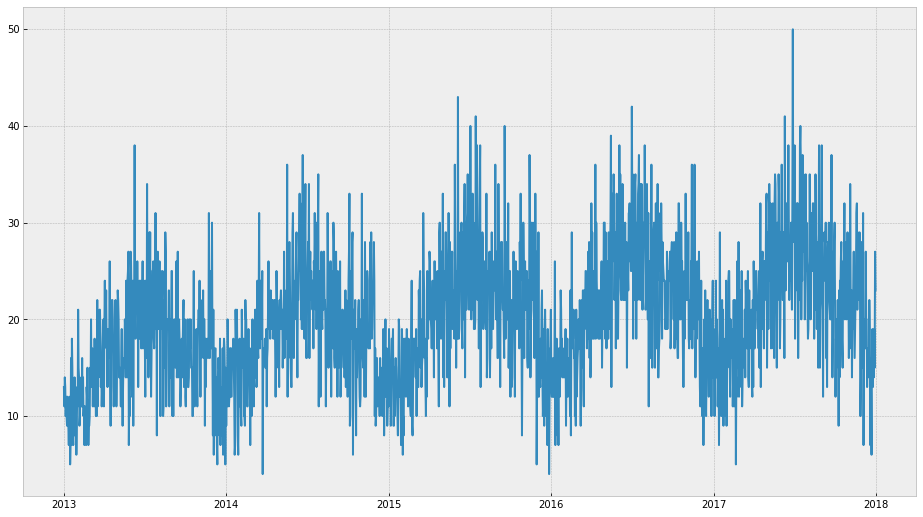

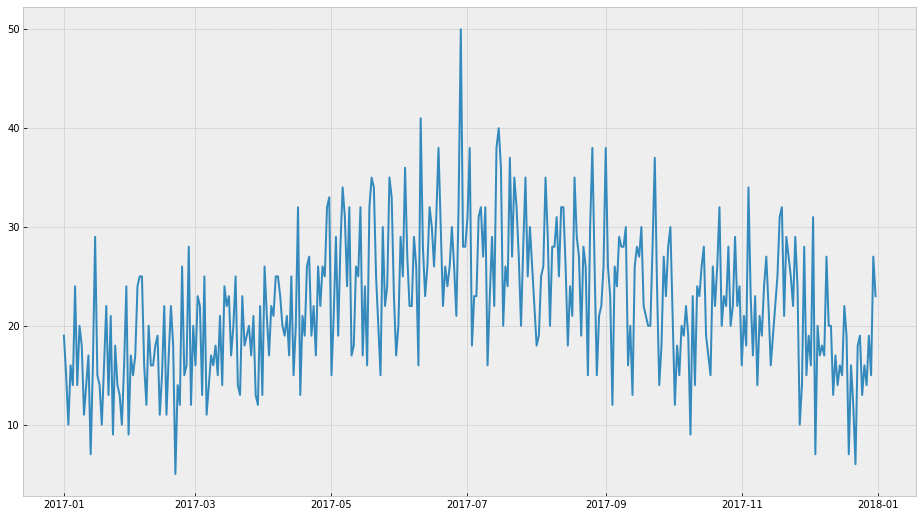

In [5]:
# Let's see what a time series looks like using matplotlib
store_1_item_1_time_series = data[data['store'].eq(1) & data['item'].eq(1)]['sales']
plt.plot(store_1_item_1_time_series)
plt.show()

# Last year
plt.plot(store_1_item_1_time_series.iloc[-365:])
plt.show()

# Clear seasonality patterns are evident in the graph, with peaks during the summer months
# The series is also characterized by a positive growth trend

,store,item,sales,day of week,day name
date,,,,,
2013-01-01,1,1,13,1,Tuesday
2013-01-02,1,1,11,2,Wednesday
2013-01-03,1,1,14,3,Thursday
2013-01-04,1,1,13,4,Friday
2013-01-05,1,1,10,5,Saturday


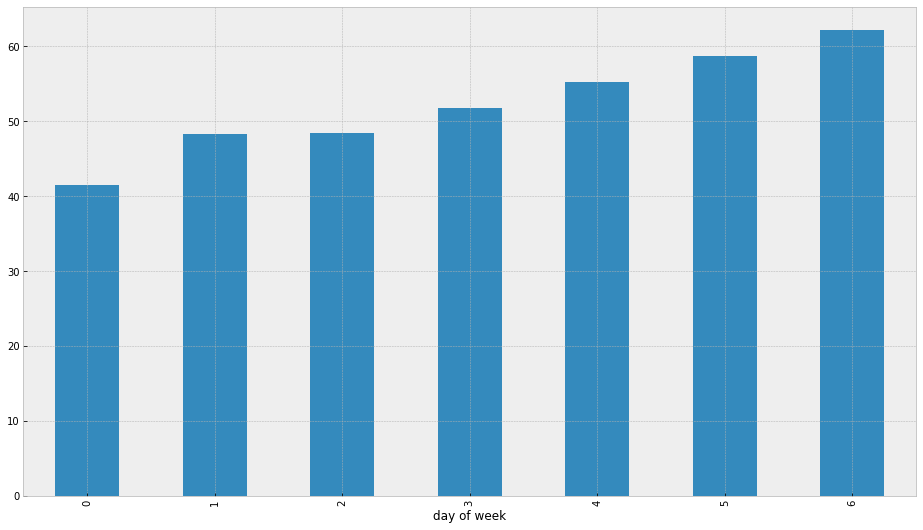

In [6]:
# Check whether weekly seasonality exists
data['day of week'] = data.index.dayofweek # add day of week column
data['day name'] = data.index.day_name()
display(data.head())
data.groupby('day of week')['sales'].mean().plot(kind='bar')
plt.show()
# Sales seem to be slighly larger during the weekends

# Drop the time period columns columns so we can later work on the original dataframe
data = data.drop(['day of week', 'day name'], axis=1) 

# Linear Regression

In [23]:
# In order to perform a linear regression on the seasonal components, we must first convert the data
# transforming categorical variables to dummy variables

def preprocess_series(series):
    data = pd.DataFrame()
    data['sales'] = series
    data['month'] = series.index.month # For monthly seasonality
    data['day_of_week'] = series.index.dayofweek # For weekly seasonality
    data['year'] = series.index.year # To account for trend
    # Convert seasonal variables to dummies
    data = pd.get_dummies(data, columns=['month', 'day_of_week'], drop_first=True)
    return data

In [8]:
# Check the output of a function
preprocessed_series = preprocess_series(store_1_item_1_time_series)
preprocessed_series.head()

,sales,year,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
date,,,,,,,,,,,,,,,,,,,
2013-01-01,13,2013,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2013-01-02,11,2013,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2013-01-03,14,2013,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2013-01-04,13,2013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2013-01-05,10,2013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [9]:
# I'll now define some data manipulation functions that will be useful during training

# In general, we will want to train the algorithm on roughly 70-90% of the data, and then evaluate
# the performance on the rest. We will take the last year of data to evaluate the algorithm performance

def get_training_and_test_data(data):
    train_data_index = (data.index < '2017-01-01')
    train_data = data.loc[train_data_index] 
    test_data = data.loc[~train_data_index] # Take the complement of the train set for the test set
    return train_data, test_data

In [10]:
# This function simply splits the datasets, returning one table with regressors, and a series with
# the target variable

def split_regressors_and_target_variables(data, target_variable='sales'):
    regressors = data.drop(target_variable, axis=1)
    target = data[target_variable]
    return regressors, target

In [11]:
# Now we're ready to train our first model!

train_data, test_data = get_training_and_test_data(preprocessed_series)
X_train, y_train = split_regressors_and_target_variables(train_data)
X_test, y_test = split_regressors_and_target_variables(test_data)

In [12]:
# Instantiate an ordinary least squares regression model
model = sm.OLS(y_train, X_train)
# Train the model
model = model.fit()
# Now you can get the predictions on the test set
predictions = model.predict(X_test)

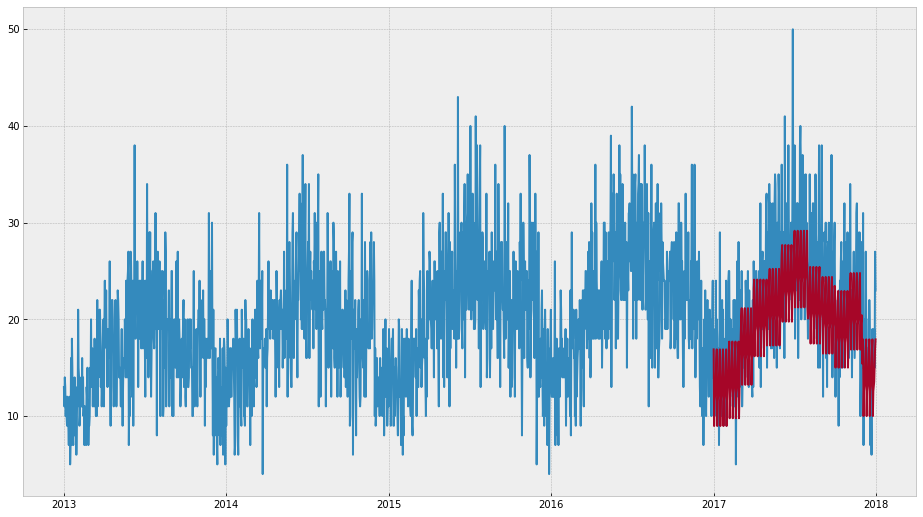

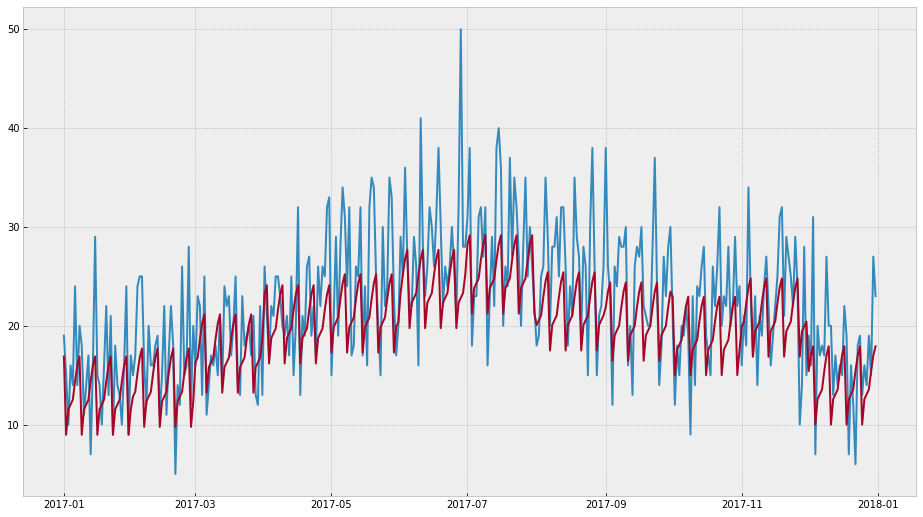

In [13]:
# Let's check how our model did on this example series with matplotlib
plt.plot(store_1_item_1_time_series)
plt.plot(predictions)
plt.show()

plt.plot(y_test)
plt.plot(predictions)
plt.show()

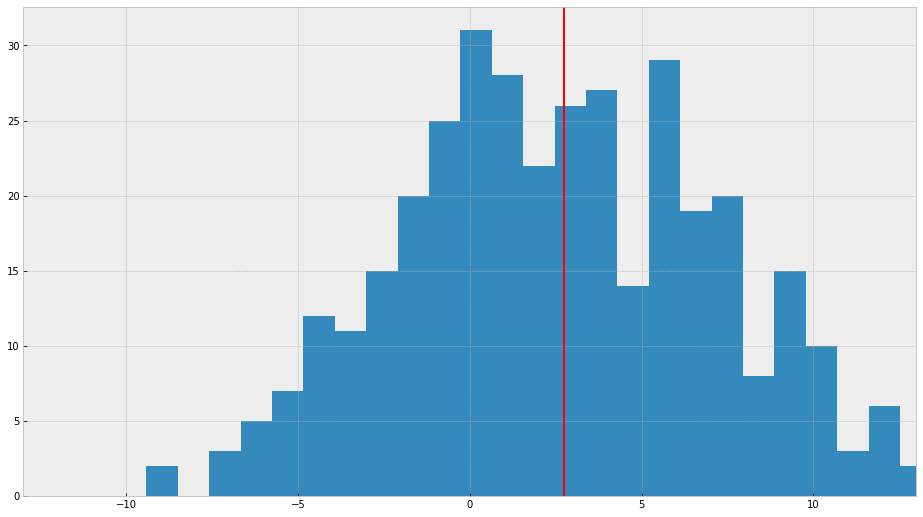

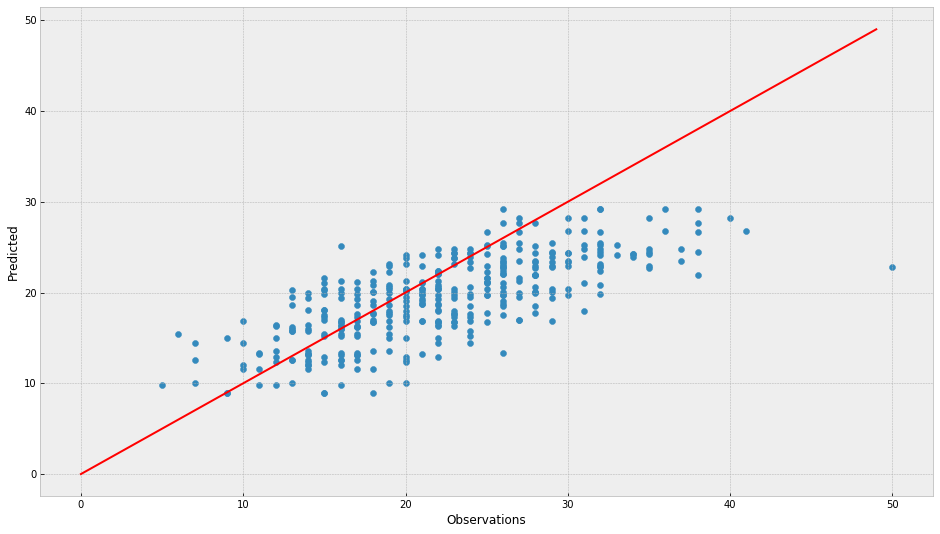

In [14]:
# It seems that in this particular case the model underestimated demand
# Let's check the error distribution
errors = y_test - predictions
mean_error = errors.mean()
plt.hist(errors, bins=40)
plt.xlim(-13, 13)
plt.axvline(mean_error, c='red')
plt.show()

# Let's see how predictions and observations are correlated
plt.scatter(y_test, predictions)
plt.xlabel('Observations')
plt.ylabel('Predicted')
plt.plot(list(range(50)), list(range(50)), color='red')
plt.show()

In [15]:
# We should calculate the Root Mean Squared Error (RMSE), in order to compare the performances 
# of each algorithm
def rmse(observations, predictions):
    return np.sqrt(np.square(observations - predictions).mean())

print(f'The RMSE was {rmse(y_test, predictions)}')

The RMSE was 5.536602770478944


In [24]:
# Good, now that we established the workflow for a single series, we should apply the algorithm to
# the whole dataset. We will be iterating through stores and items, performing a forecast 
# for each time series.
# We can take advantage of the pandas library group by function, but first let's wrap the whole
# training and prediction procedure in a single function:

def perform_linear_regression_forecast_on_series(series):
    series = preprocess_series(series)
    train_data, test_data = get_training_and_test_data(series)
    X_train, y_train = split_regressors_and_target_variables(train_data)
    X_test, y_test = split_regressors_and_target_variables(test_data)
    model = sm.OLS(y_train, X_train)
    model = model.fit()
    predictions = model.predict(X_test)
    return predictions

In [25]:
%%time
# Let's apply the function to the dataset grouped by store and item
# Let's also time the algorithm, so we can later on evaluate how fast the algorithms were

result = (data.groupby(['store', 'item'])['sales']
              .apply(perform_linear_regression_forecast_on_series)
              .to_frame()
              .rename(columns={'sales': 'predicted'}))


Wall time: 11.2 s


In [26]:
result

predicted
store item date                 
1     1    2017-01-01  16.896689
           2017-01-02   8.971285
           2017-01-03  11.550655
           2017-01-04  12.050509
           2017-01-05  12.524238
...                          ...
10    50   2017-12-27  49.644798
           2017-12-28  54.296062
           2017-12-29  58.733136
           2017-12-30  63.144906
           2017-12-31  67.818274

[182500 rows x 1 columns]

In [27]:
# Merge with the original dataframe
forecast = data.merge(result, on=['date', 'store', 'item'])
forecast.head(10)

,store,item,sales,predicted
date,,,,
2017-01-01,1,1,19,16.896689
2017-01-02,1,1,15,8.971285
2017-01-03,1,1,10,11.550655
2017-01-04,1,1,16,12.050509
2017-01-05,1,1,14,12.524238
2017-01-06,1,1,24,14.390774
2017-01-07,1,1,14,15.972613
2017-01-08,1,1,20,16.896689
2017-01-09,1,1,18,8.971285


In [28]:
# Save the result in the /Results folder
forecast.to_csv('Results/Linear_Regression.csv')

In [29]:
# Let's evaluate the performance of the Linear Regression model over the whole test dataset
print(f'The overall RMSE was {rmse(forecast.sales, forecast.predicted)}')
print(f'The mean error was {(forecast.sales - forecast.predicted).mean()}')

The overall RMSE was 12.076787816661742
The mean error was 8.138578542248561


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-07-02,2,15,231,161.113744,69.886256,69.886256
2017-07-05,8,15,193,126.800335,66.199665,66.199665
2017-08-20,2,18,201,136.993416,64.006584,64.006584
2017-07-16,9,28,195,131.651272,63.348728,63.348728
2017-07-16,9,18,187,124.625851,62.374149,62.374149
2017-06-02,8,15,192,129.896887,62.103113,62.103113
2017-06-17,3,13,185,123.558503,61.441497,61.441497
2017-07-01,8,28,204,145.974912,58.025088,58.025088
2017-08-25,2,10,165,107.133457,57.866543,57.866543


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-01-10,8,1,15,14.999514,0.000486,0.000486
2017-12-05,5,14,29,28.999594,0.000406,0.000406
2017-02-09,6,22,44,43.999633,0.000367,0.000367
2017-09-01,4,16,29,28.999681,0.000319,0.000319
2017-09-08,4,16,29,28.999681,0.000319,0.000319
2017-11-03,4,38,91,91.000289,-0.000289,0.000289
2017-08-21,2,41,25,24.999751,0.000249,0.000249
2017-03-15,1,33,51,51.000236,-0.000236,0.000236
2017-03-30,2,6,65,64.999827,0.000173,0.000173


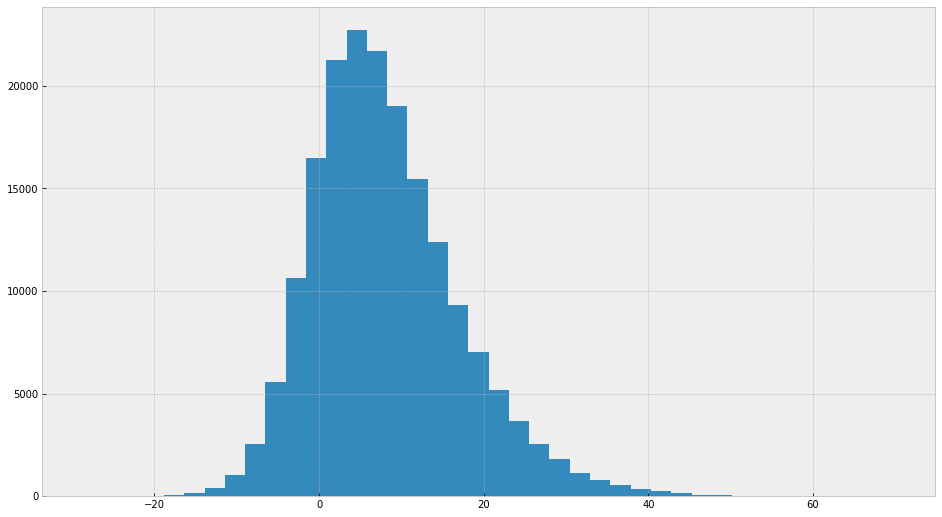

In [30]:
# It looks like the RMSE calculated over the test dataset was significantly higher than in the
# first example. It also looks like the forecast was too pessimistic, as sales tended to be higher
# than the predictions. Let's see where the algorithm was least (and most) accurate
forecast['error'] = forecast['sales'] - forecast['predicted']
forecast['absolute_error'] = np.abs(forecast['error'])
sorted_by_abs_err = forecast.sort_values('absolute_error', ascending=False)
display(sorted_by_abs_err.head(10))
display(sorted_by_abs_err.tail(10))

plt.hist(forecast['error'], bins=40)
plt.show()

In [31]:
# Since all of our models' outputs will be the same (date, store, item: prediction), we might 
# as well create a function to saves the results, and analyzes them.
# I also added a function for plotting errors and correlations

def plot_error_graphs(actual, predicted):
    errors = actual - predicted
    mean_error = errors.mean()
    plt.hist(errors, bins=40)
    plt.axvline(mean_error, c='red')
    plt.show()

    plt.scatter(actual, predicted)
    plt.xlabel('Observations')
    plt.ylabel('Predicted')
    line_length = actual.max()
    coordinates = list(range(line_length))
    plt.plot(x=coordinates, y=coordinates, color='red', alpha=0.5)
    plt.show()


def model_report(original_data, model_output, model_name, n_rows_to_display=10):
    forecast = original_data.merge(model_output, on=['date', 'store', 'item'])
    forecast.to_csv('Results/' + model_name + '.csv')
    forecast['error'] = forecast['sales'] - forecast['predicted']
    forecast['absolute_error'] = np.abs(forecast['error'])
    sorted_by_abs_err = forecast.sort_values('absolute_error', ascending=False)
    print('Most inaccurate')
    display(sorted_by_abs_err.head(n_rows_to_display))
    print('Most accurate')
    display(sorted_by_abs_err.tail(n_rows_to_display))
    print(f'The overall RMSE was {rmse(forecast.sales, forecast.predicted)}')
    print(f'The mean error was {(forecast.sales - forecast.predicted).mean()}')
    plot_error_graphs(forecast['sales'], forecast['predicted'])

# Random Forest

In [34]:
# Let's now apply the random forest regression algorithm. Luckily some of the steps to perform
# in order to apply this algorithm, are the same as for linear regression, and we can reuse some
# functions. We'll be using the same workflow as before, namely, group by, fit, forecast,
# combine results, and evaluate the model

def perform_rf_forecast_on_series(series):
    
    series = preprocess_series(series)
    train_data, test_data = get_training_and_test_data(series)
    X_train, y_train = split_regressors_and_target_variables(train_data)
    X_test, y_test = split_regressors_and_target_variables(test_data)
    model = RandomForestRegressor(n_estimators=100)
    model = model.fit(X_train, y_train)
    predictions = model.predict(X_test) # Prediction is a numpy.array
    predictions = pd.Series(data=predictions,
                            index=y_test.index,
                            name='sales') # Convert to a pandas series
    return predictions

# Since we are going to use this workflow many times, let's just create a function for our workflow
# So we don't have to type the same stuff over and over
def predict_all_series(data, function_to_apply):
    result = (data.groupby(['store', 'item'])['sales']
                  .apply(function_to_apply)
                  .to_frame()
                  .rename(columns={'sales': 'predicted'}))
    return result

In [35]:
%%time
rf_forecast = predict_all_series(data, perform_rf_forecast_on_series)

Wall time: 1min 46s


In [36]:
rf_forecast

predicted
store item date                 
1     1    2017-01-01  17.216794
           2017-01-02  10.374687
           2017-01-03  14.837008
           2017-01-04  13.041520
           2017-01-05  15.159401
...                          ...
10    50   2017-12-27  51.184619
           2017-12-28  60.252044
           2017-12-29  70.962115
           2017-12-30  70.433849
           2017-12-31  63.714357

[182500 rows x 1 columns]

Most inaccurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-08-20,2,18,201,144.723234,56.276766,56.276766
2017-06-02,8,15,192,138.875857,53.124143,53.124143
2017-11-10,10,15,154,101.811591,52.188409,52.188409
2017-07-05,8,15,193,142.120643,50.879357,50.879357
2017-07-30,3,8,178,129.764034,48.235966,48.235966
2017-11-12,3,11,139,90.770425,48.229575,48.229575
2017-06-17,2,2,150,101.905401,48.094599,48.094599
2017-08-27,2,45,183,135.618965,47.381035,47.381035
2017-03-10,8,8,131,84.075357,46.924643,46.924643


Most accurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-07-08,9,47,36,35.999623,0.000377,0.000377
2017-07-29,9,47,36,35.999623,0.000377,0.000377
2017-11-10,8,42,56,55.999647,0.000353,0.000353
2017-01-31,1,19,27,26.999651,0.000349,0.000349
2017-05-06,5,36,83,83.000343,-0.000343,0.000343
2017-10-18,8,11,80,79.999721,0.000279,0.000279
2017-01-08,7,32,29,28.999766,0.000234,0.000234
2017-02-28,10,46,49,49.000159,-0.000159,0.000159
2017-06-27,3,30,57,56.999869,0.000131,0.000131


The overall RMSE was 8.849885597337554
The mean error was 2.2420686972509873


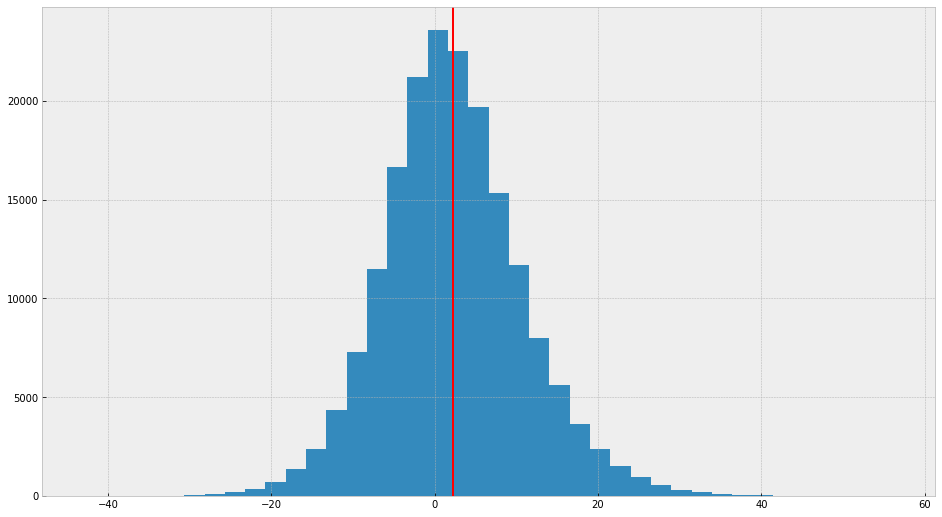

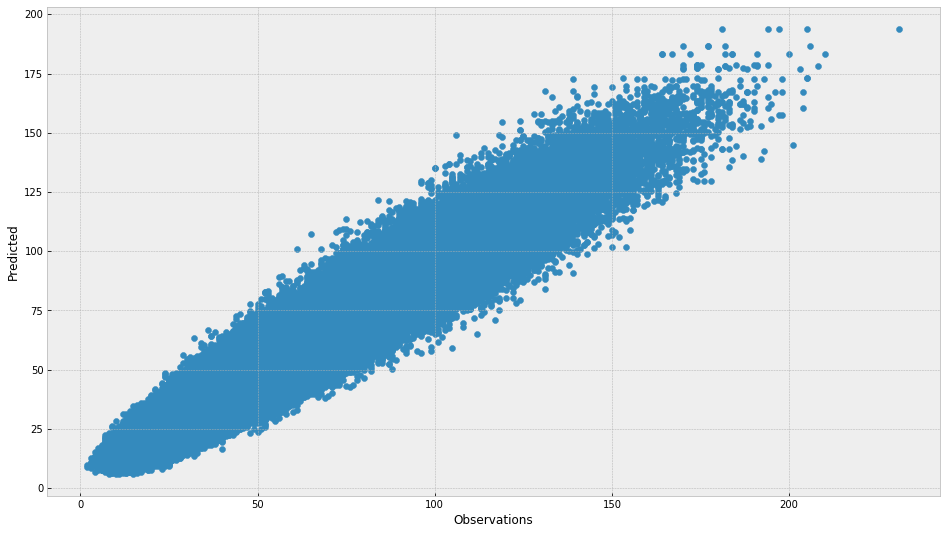

In [37]:
model_report(original_data=data,
             model_output=rf_forecast,
             model_name='RandomForest')

# ARIMA

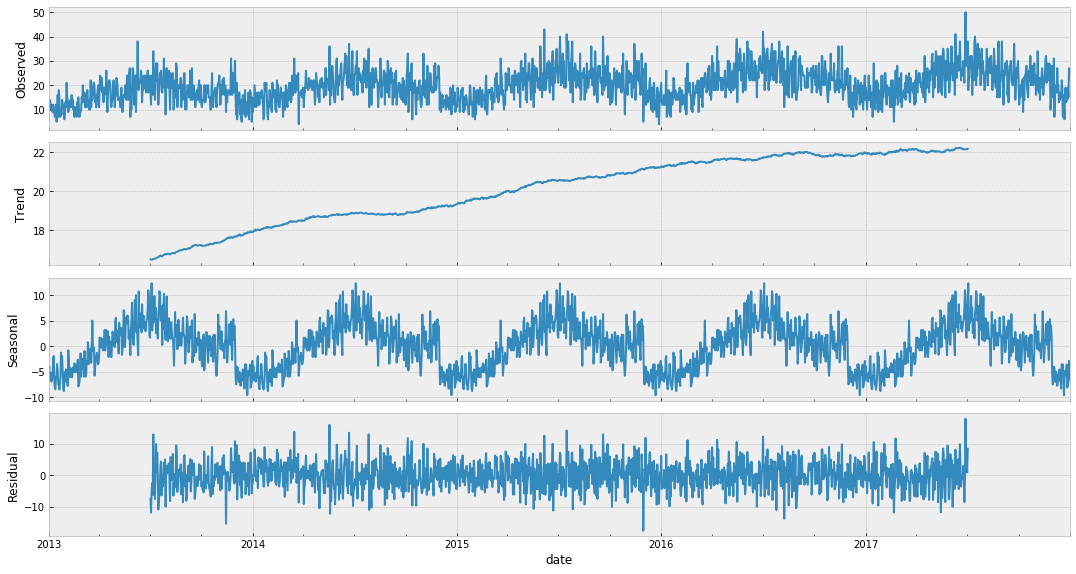

In [50]:
# First of all let's take a look at the seasonal trend decomposition of a single series
res = sm.tsa.seasonal_decompose(store_1_item_1_time_series, freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

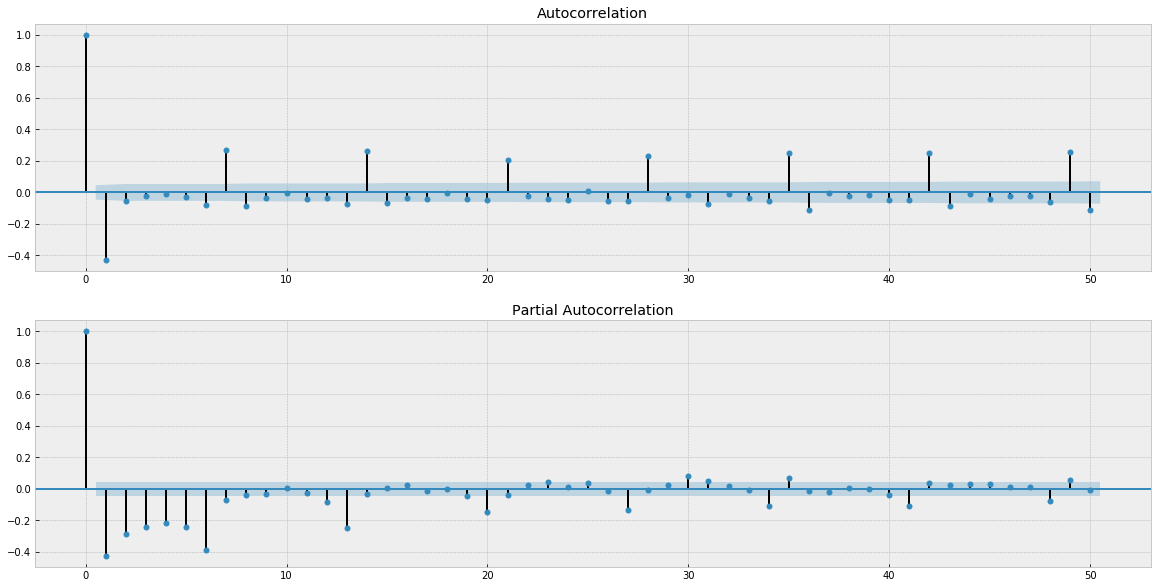

In [54]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(store_1_item_1_time_series.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(store_1_item_1_time_series.diff().dropna(), lags=50, ax=ax[1])
plt.show()

# From the autocorrelation plot, a weekly seasonality is noticeable

In [67]:
def perform_sarima_forecast_on_series(series):

    train_data, test_data = get_training_and_test_data(series)
    sarima = sm.tsa.statespace.SARIMAX(train_data,
                                       order=(7,1,7),
                                       seasonal_order=(1,0,5,1),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,
                                       freq='D').fit()
    predictions = sarima.predict(start=test_data.index[0],
                                 end=test_data.index[-1])
    return predictions

In [68]:
%%time
sar_result = predict_all_series(data, perform_sarima_forecast_on_series)

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

Most inaccurate


,date,store,item,sales,predicted,error,absolute_error
51647,2017-07-02,2,15,231,114.295849,116.704151,116.704151
99103,2017-07-08,2,28,206,89.461873,116.538127,116.538127
62603,2017-07-08,2,18,204,89.803668,114.196332,114.196332
101286,2017-07-01,8,28,204,93.705409,110.294591,110.294591
51666,2017-07-21,2,15,198,89.582415,108.417585,108.417585
44354,2017-07-09,2,13,210,102.075706,107.924294,107.924294
51673,2017-07-28,2,15,197,89.461388,107.538612,107.538612
101666,2017-07-16,9,28,195,87.739620,107.260380,107.260380
65166,2017-07-16,9,18,187,80.084056,106.915944,106.915944
53807,2017-06-02,8,15,192,86.360562,105.639438,105.639438


Most accurate


,date,store,item,sales,predicted,error,absolute_error
47486,2017-02-06,1,14,33,32.997459,0.002541,0.002541
130304,2017-12-31,7,36,53,52.997906,0.002094,0.002094
31013,2017-12-20,5,9,29,28.997935,0.002065,0.002065
159178,2017-02-08,7,44,14,13.998004,0.001996,0.001996
71865,2017-11-22,7,20,25,25.001964,-0.001964,0.001964
105925,2017-03-17,1,30,33,33.001685,-0.001685,0.001685
58674,2017-10-02,1,17,23,22.998364,0.001636,0.001636
32132,2017-01-13,9,9,45,45.000571,-0.000571,0.000571
102576,2017-01-12,2,29,70,69.999789,0.000211,0.000211
160961,2017-12-28,1,45,54,54.000135,-0.000135,0.000135


The overall RMSE was 23.058344845364974
The mean error was 15.874839503786406


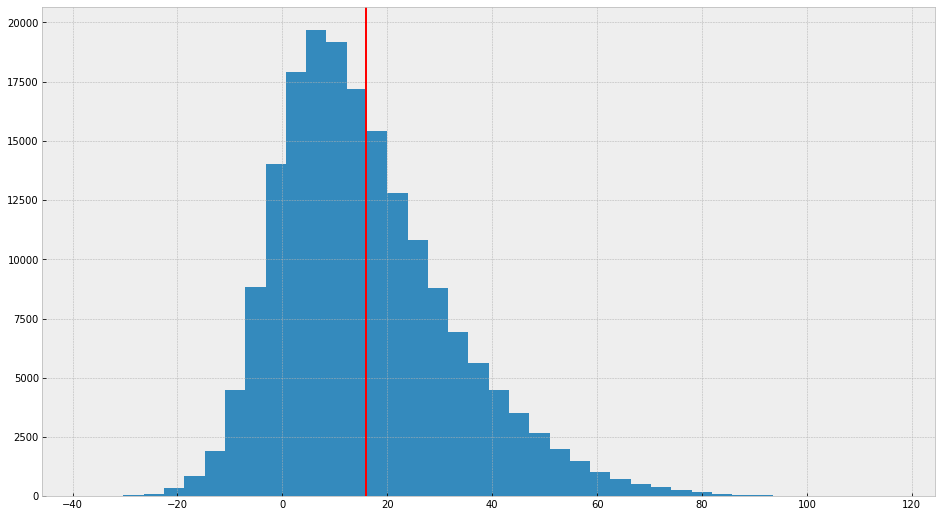

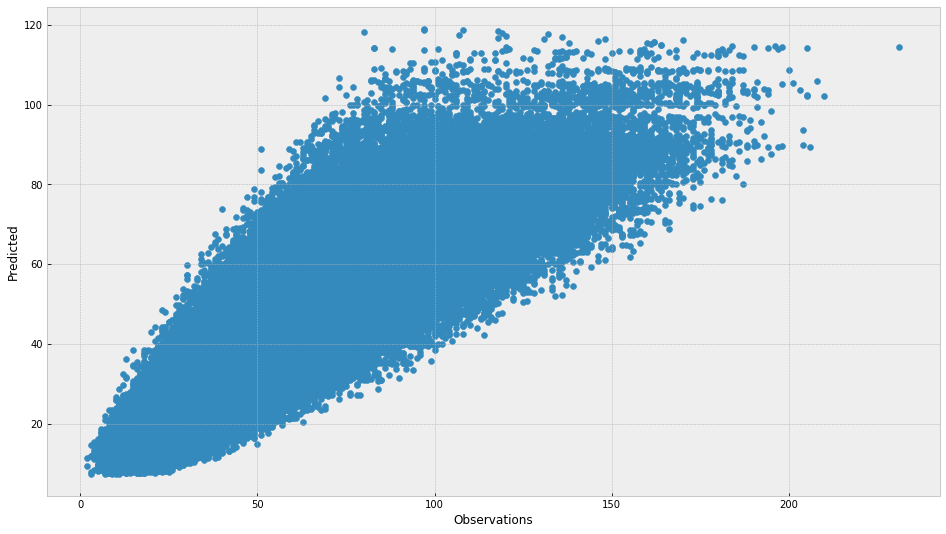

In [78]:
# Renaming the date column, because the statsmoels implementation for sarima is dumb
sar_result = sar_result.reset_index().rename(columns={'level_2': 'date'})
model_report(data, sar_result, model_name='Sarima')